# Main notebook

- DCGAN Adapted from [this tutorial](https://keras.io/examples/generative/dcgan_overriding_train_step/)
- VAE adapted from this [tutorial](https://keras.io/examples/generative/vae/#train-the-vae)

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile
from pathlib import Path
import time

In [2]:
import sys
def is_in_collab_env():
    return 'google.colab' in sys.modules

if is_in_collab_env():
    from google.colab import drive
    drive.mount('/content/drive')
    ROOT = Path("/content/drive/MyDrive/INF8225/notebooks")
else:
    ROOT = Path('..').resolve()

Mounted at /content/drive


In [3]:
DATA_PATH = ROOT/"data"
MODEL_PATH = ROOT/"models"

DATA_PATH.mkdir(parents=True, exist_ok=True)
MODEL_PATH.mkdir(parents=True, exist_ok=True)

## Prepare CelebA data

We'll use face images from the CelebA dataset, resized to 64x64.

In [4]:
os.makedirs("celeba_gan", exist_ok=True)

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")

In [ ]:
# https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1):
    assert (train_split + test_split + val_split) == 1

    ds_size = tf.data.experimental.cardinality(ds).numpy()
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [5]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)
train, valid, test = get_dataset_partitions_tf(dataset)

Found 202599 files belonging to 1 classes.


Let's display a sample image:

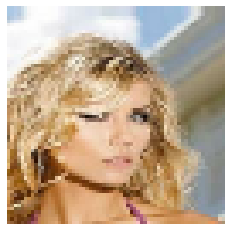

In [6]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break


## Architectures

### DCGAN

In [12]:
class GAN(keras.Model):
    def __init__(self, latent_dim):
        super(GAN, self).__init__()
        self.latent_dim = latent_dim
        self.discriminator = self.__get_discriminator()
        self.generator = self.__get_generator()

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def get_generator(self):
        return self.generator

    def __get_discriminator(self):
        return keras.Sequential(
                [
                    keras.Input(shape=(64, 64, 3)),
                    layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
                    layers.LeakyReLU(alpha=0.2),
                    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
                    layers.LeakyReLU(alpha=0.2),
                    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
                    layers.LeakyReLU(alpha=0.2),
                    layers.Flatten(),
                    layers.Dropout(0.2),
                    layers.Dense(1, activation="sigmoid"),
                ],
                name="discriminator",
            )
    def __get_generator(self):
        return keras.Sequential(
            [
                keras.Input(shape=(self.latent_dim,)),
                layers.Dense(8 * 8 * 128),
                layers.Reshape((8, 8, 128)),
                layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
                layers.LeakyReLU(alpha=0.2),
                layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
                layers.LeakyReLU(alpha=0.2),
                layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
                layers.LeakyReLU(alpha=0.2),
                layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
            ],
            name="generator",
        )
    
    def generate_samples(self, num_img):
        """
        Generates num_img images.
            Returns:
                imgs: an array of PIL images
        """
        random_latent_vectors = tf.random.normal(shape=(num_img, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        imgs = [ keras.preprocessing.image.array_to_img(generated_image) for generated_image in generated_images]
        return imgs

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


### VAE


In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, latent_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.encoder = self.__get_encoder()
        self.decoder = self.__get_decoder()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def get_generator(self):
        return self.decoder

    def __get_encoder(self):
        encoder_inputs = keras.Input(shape=(64, 64, 3)) # avant 28, 28, 1
        x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
        x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Flatten()(x)
        x = layers.Dense(self.latent_dim, activation="relu")(x)
        z_mean = layers.Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(self.latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
        return keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    def __get_decoder(self):
        latent_inputs = keras.Input(shape=(self.latent_dim,))
        x = layers.Dense(16 * 16 * 64, activation="relu")(latent_inputs) # avant: 7 * 7 * 64
        x = layers.Reshape((16, 16, 64))(x) # avant: 7,7,64
        x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(rate=0.25)(x)
        x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(rate=0.25)(x)
        decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
        return keras.Model(latent_inputs, decoder_outputs, name="decoder")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def predict(self, input):
        z_mean, z_log, z = self.encoder.predict(input)
        return self.decoder.predict(z)

## Training code

### Callbacks

In [8]:
class SaveImagesCallback(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128, epoch_offset=0):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.epoch_offset = epoch_offset

    def on_epoch_end(self, epoch, logs=None):
        epoch_adjusted = self.epoch_offset+epoch
        if (epoch_adjusted % 10) == 0:
            random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
            generator = self.model.get_generator()
            generated_images = generator(random_latent_vectors)
            generated_images *= 255
            generated_images.numpy()
            
            dir_name = f'DCGAN_CelebA-e:{epoch_adjusted}'
            img_path = DATA_PATH/dir_name
            img_path.mkdir(parents=True, exist_ok=True)
            crnt_timestamp = str(time.time()).split('.')[0]
            for i in range(self.num_img):
                img = keras.preprocessing.image.array_to_img(generated_images[i])
                img.save(img_path/f'generated_img_e:{epoch_adjusted}_{i}_t:{crnt_timestamp}.png')


### Training

In [13]:
## Model configuration
load_weights = False
weights_path = MODEL_PATH/'DCGAN_CelebA-70+30'
latent_dim = 128

## Training specifics
epochs = 30 # In practice, use ~100 epochs

In [14]:
def get_GAN(load_weights= False, weights_path=None):
    """
    Parameters:
        load_weights: When set to true, loads weights
        weights_path: The path to the weights
    Returns:
        gan
    """
    gan = GAN(latent_dim)
    gan.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss_fn=keras.losses.BinaryCrossentropy(),
    )
    if load_weights:
        gan.load_weights(weights_path)
    return gan

In [15]:
gan = get_GAN(load_weights, weights_path)

In [ ]:
save_images_callback = SaveImagesCallback(num_img=10, latent_dim=latent_dim)
mcp_save = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH/'DCGAN_CelebA-{epoch:02d}',period=10, save_weights_only=True)

gan.fit(
    dataset, epochs=epochs, callbacks=[save_images_callback, mcp_save]
)

Some of the last generated images around epoch 30
(results keep improving after that):

![results](https://i.imgur.com/h5MtQZ7l.png)

## Evaluation


In [18]:
load_weights=True
weights_path=MODEL_PATH/'DCGAN_CelebA-01'

In [19]:
gan = get_GAN(load_weights, weights_path)

Generating images

In [20]:
# n_samples = 100

# # Generate samples
# imgs = gan.generate_samples(n_samples)

# # Initialize directory for pictures
# dir_name = f'DCGAN_CelebA-generated'
# img_path = DATA_PATH/dir_name
# img_path.mkdir(parents=True, exist_ok=True)

# # Save images
# for i, img in enumerate(imgs):
#     img.save(img_path/f'generated_img_{i}.png')

Saving random images **TODO fix with test**

In [ ]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(64, 64), batch_size=32
)
# https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1):
    assert (train_split + test_split + val_split) == 1
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

size = tf.data.experimental.cardinality(dataset).numpy()
train, _, test = get_dataset_partitions_tf(dataset, size)

Found 202599 files belonging to 1 classes.


In [ ]:
dir_name = f'DCGAN_CelebA-real'

real_img_path = DATA_PATH/'DCGAN_CelebA-real'
real_img_path.mkdir(parents=True, exist_ok=True)

gen_img_path = DATA_PATH/'DCGAN_CelebA-gen'
gen_img_path.mkdir(parents=True, exist_ok=True)

i = 0
for image_batch in test.as_numpy_iterator():
    for j in range(image_batch.shape[0]): # batch of 32
        # Generating img + saving it
        img_gen = gan.generate_samples(1)[0]
        img_gen.save(gen_img_path/f'{i}.png')

        # Saving real image
        img_real = image_batch[j,...]
        plt.imsave(real_img_path/f'{i}.png', img_real / 255)
        i += 1

KeyboardInterrupt: ignored

## FID

In [ ]:
!pip install pytorch-fid

  Created wheel for pytorch-fid: filename=pytorch_fid-0.2.1-py3-none-any.whl size=14835 sha256=5090abf0d28a2ecc5e60f0bebd08b90fda9e408801d191841ef0be954cba2519
  Stored in directory: /root/.cache/pip/wheels/24/ac/03/c5634775c8a64f702343ef5923278f8d3bb8c651debc4a6890
Successfully built pytorch-fid


In [ ]:
!python -m pytorch_fid $real_img_path $gen_img_path --device cuda:0

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:05<00:00, 17.2MB/s]
100% 719/719 [02:53<00:00,  4.14it/s]
100% 333/333 [01:12<00:00,  4.60it/s]
FID:  51.430461225018604


FID:  51.430461225018604

## Specificity

In [ ]:
def find_closest_img(reference_img, dataset, dist_func=None):
    """
    code below finds closest image from reference_img
    takes 2 mins for a single img ...
    """
    closest_dist = 1e9
    closest_img = None
    for image_batch in dataset.as_numpy_iterator():
        
        truth = image_batch
        distances = [tf.norm(truth[i]-reference_img) for i in range(32)]
        i = tf.math.argmin(distances).numpy()
        min_dist = distances[i]

        if closest_dist > min_dist:
            closest_dist = min_dist
            closest_img = truth[i]
    return closest_img

In [ ]:

min_dist = []
n_samples = 10
imgs = gan.generate_samples(n_samples)
for img in imgs:
    closest_img = find_closest_img(img, train)
    min_dist.append(tf.norm(img-closest_img))
print(np.mean(np.array(min_dist)))

5223.487


5223.487

# Debug

In [ ]:
!pip install -Uqq ipdb
import ipdb


In [ ]:
%pdb off

Automatic pdb calling has been turned OFF
